# Testing Model on Face Mask Detection Dataset - Part 1

This dataset of 853 images has around 4000 faces in it. These faces are have no mask, a mask correctly worn, or one incorrectly worn. All images are very real world. The model will be evaluated on this data.

In part 1, the images will be passed though the face detector to extract all availible faces. These faces will be matched with the closest label. The faces will be cropped and their labels will be saved. Any faces not detected will be recorded.

## Imports and setup

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL
from PIL import Image, ImageOps, ImageDraw
import os
import xml.dom.minidom
import math

import face_recognition

import cv2
import mediapipe as mp

In [2]:
mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils

In [3]:
fmd_img_dir = r'D:\data\face_mask\FaceMaskDetection\images'
fmd_ano_dir = r'D:\data\face_mask\FaceMaskDetection\annotations'

## Functions

In [4]:
def media_pipe_fd(cv2_img, w, h, tol=0.5):
    output = []
    with mp_face_detection.FaceDetection(
        model_selection=1, min_detection_confidence=tol) as face_detection:
        
        # Convert the BGR image to RGB and process it with MediaPipe Face Detection
        results = face_detection.process(cv2.cvtColor(cv2_img, cv2.COLOR_BGR2RGB))
        
        if results.detections:
            for detection in results.detections:
                rbb = detection.location_data.relative_bounding_box
                rect_start_point = mp_drawing._normalized_to_pixel_coordinates(
                  rbb.xmin, rbb.ymin, w,
                  h)
                rect_end_point = mp_drawing._normalized_to_pixel_coordinates(
                  rbb.xmin + rbb.width,
                  rbb.ymin + rbb.height, w,
                  h)
                if rect_start_point is None:
                    rect_start_point = (0, 0)
                    print('bouding box algo gave out of bounds box')
                if rect_end_point is None:
                    rect_end_point = (w, h)
                    print('bouding box algo gave out of bounds box')
                
                output.append((rect_start_point, rect_end_point))
    return output

In [5]:
def parse_annotations(anotation_fp):
    doc = xml.dom.minidom.parse(anotation_fp)
    objs = doc.getElementsByTagName('object')
    
    out_data = []
    for obj in objs:
        name, diff, xmin, ymin, xmax, ymax = None, None, None, None, None, None
        for node in obj.childNodes:

            #print(node)
            if node.nodeType == node.ELEMENT_NODE:
                if node.tagName == 'name':
                    name = node.firstChild.nodeValue
                elif node.tagName == 'difficult':
                    diff = node.firstChild.nodeValue
                elif node.tagName == 'bndbox':
                    for box_coord_node in node.childNodes:
                        if box_coord_node.nodeType == node.ELEMENT_NODE:

                            #print('\t' + str(box_coord_node))
                            if box_coord_node.nodeType == node.ELEMENT_NODE:
                                if box_coord_node.tagName == 'xmin':
                                    xmin = box_coord_node.firstChild.nodeValue
                                elif box_coord_node.tagName == 'ymin':
                                    ymin = box_coord_node.firstChild.nodeValue
                                elif box_coord_node.tagName == 'xmax':
                                    xmax = box_coord_node.firstChild.nodeValue
                                elif box_coord_node.tagName == 'ymax':
                                    ymax = box_coord_node.firstChild.nodeValue
        targets = [name, diff, xmin, ymin, xmax, ymax]
        if sum([x is None for x in targets]) == 0:
            box = {
                'name': name,
                'difficult': int(diff),
                'xmin': int(xmin),
                'ymin': int(ymin),
                'xmax': int(xmax),
                'ymax': int(ymax)

            }
            out_data.append(box)
    return out_data

In [6]:
def anotation_to_box_coords(anotation):
    xmin = anotation['xmin']
    ymin = anotation['ymin']
    xmax = anotation['xmax']
    ymax = anotation['ymax']
    
    bl = (xmin, ymax)
    tr = (xmax, ymin)
    return (bl, tr)

In [7]:
def norm_coords(coord, w, h):
    x, y = coord
    return (x/w, y/h)

In [8]:
def euclidian_dist(coord1, coord2):
    x1, y1 = coord1
    x2, y2 = coord2
    
    xd = x2 - x1
    yd = y2 - y1
    return math.sqrt(xd ** 2 + yd ** 2)

In [9]:
def correct_crop(xl, xr, yt, yb, w, h):
    if yt < 0:
        diff = abs(yt)
        yt = 0
        expand_left = int(diff / 2)
        expand_right = diff - expand_left
        xl = xl - expand_left
        xr = xr + expand_right
    if xl < 0:
        diff = abs(xl)
        xl = 0
        expand_down = int(diff / 2)
        expand_up = diff - expand_down
        yb = yb + expand_down
        yt = yt - expand_up
    if yb > h:
        diff = yb - h
        yb = h
        expand_left = int(diff / 2)
        expand_right = diff - expand_left
        xl = xl - expand_left
        xr = xr + expand_right
    if xr > w:
        diff = xr - w
        xr = w
        expand_down = int(diff / 2)
        expand_up = diff - expand_down
        yb = yb + expand_down
        yt = yt - expand_up
    if yt < 0 or xl < 0 or yb > h or xr > w:
        print('coords error after correction')
    return xl, xr, yt, yb

In [10]:
def rect_square_expansion(xl, xr, yt, yb, w, h):
    bbh = yb - yt
    bbw = xr - xl
    if bbh > bbw:
        diff = bbh - bbw
        expand_left = int(diff/2)
        expand_right = diff - expand_left
        xl = xl - expand_left
        xr = xr + expand_right
    elif bbw > bbh:
        diff = bbw - bbh
        expand_down = int(diff/2)
        expand_up = diff - expand_down
        yb = yb + expand_down
        yt = yt - expand_up
    
    return xl, xr, yt, yb

## Extraction

In [67]:
# config options
match_tolerance = 0.11
algo_tol = 0.5
# input dirs
fmd_image_root = r'D:\data\face_mask\FaceMaskDetection\images'
fmd_ano_root = r'D:\data\face_mask\FaceMaskDetection\annotations'
# output dirs
correctly_worn_out_dir = r'D:\data\face_mask\FMDDetected2\correct'
incorrectly_worn_out_dir = r'D:\data\face_mask\FMDDetected2\incorrect'
# intended dimensions of the output. 
target_h = 112
target_w = target_h  # enforce square


total_detections = 0
misses = 0
counts = {
    'total': 0,
    'mask': 0,
    'no mask': 0,
    'incorrect mask': 0,
    'detected mask': 0,
    'detected wo mask': 0,
    'detected w incorrect mask': 0,
}
img_counter = 0
for root, subdirectories, files in os.walk(fmd_image_root):
    for file in files:
        # get image and annotation file path
        img_fp = os.path.join(fmd_image_root, file)
        ano_fp = os.path.join(fmd_ano_root, file[:-3] + 'xml')

        # read the image
        image = cv2.imread(img_fp)
        h, w, d = image.shape

        # use the supplied face detector to detect faces
        bbs = media_pipe_fd(image, w, h, tol=algo_tol)
        total_detections += len(bbs)

        # parse annotation file 
        anotations = parse_annotations(ano_fp)

        # match annotations to algo bounding box if under threshold
        for anotation in anotations:
            bl, tr = anotation_to_box_coords(anotation)
            # correct to mediapipe format
            txl, tyb = bl
            txr, tyt = tr
            corrected_bl = (txl, tyt)
            corrected_tr = (txr, tyb)
            bl = corrected_bl
            tr = corrected_tr
            
            # thresh = match_tolerance * math.sqrt(w * h)  # geometric mean
            thresh = match_tolerance * ((w + h) / 2)  # arithmetric mean
            
            # switch to closest scheme with both params
            
            match = None
            closest_dist = 10000000
            for bb in bbs:
                #dist = euclidian_dist(bl, bb[0])
                #dist += euclidian_dist(tr, bb[1]
                dist1 = euclidian_dist(bl, bb[0])
                dist2 = euclidian_dist(tr, bb[1])
                if (dist1 + dist2) < closest_dist:
                    closest_dist = dist
                    match = bb
            if dist2 > thresh or dist2 > thresh:
                #print(file)
                #print('over threshold match of {:.2f}. Thresh is {:.2f}'.format(closest_dist, thresh))
                temp=match
                match = None
                break

            # collect metrics
            if match is not None:
                amt_to_inc = 1
            else:
                amt_to_inc = 0
                misses += 1
            counts['total'] += 1
            # mask
            if anotation['name'] == 'with_mask':
                counts['mask'] += 1
                counts['detected mask'] += amt_to_inc
            # no mask
            elif anotation['name'] == 'without_mask':
                counts['no mask'] += 1
                counts['detected wo mask'] += amt_to_inc
            # incorrect mask
            elif anotation['name'] == 'mask_weared_incorrect':
                counts['incorrect mask'] += 1
                counts['detected w incorrect mask'] += amt_to_inc

            # crop image
            if match is not None:
                # crop to square
                rect_start_point, rect_end_point = bb
                xl, yt = rect_start_point
                xr, yb = rect_end_point
                xl, xr, yt, yb = rect_square_expansion(xl, xr, yt, yb, w, h)
                # if expansion push box out of image bounds, reduce size of box
                xl, xr, yt, yb = correct_crop(xl, xr, yt, yb, w, h)
                
                # expand if nessisary
                expansion = .125
                bbh = yb - yt
                bbw = xr - xl
                amt_to_add = int(expansion * max(bbh, bbw))
                yt = yt - amt_to_add
                yb = yb + amt_to_add
                xl = xl - amt_to_add
                xr = xr + amt_to_add
                
                # correct crop boundaries again if any expansion pushed crop outside image window
                xl, xr, yt, yb = correct_crop(xl, xr, yt, yb, w, h)
                xl, xr, yt, yb = correct_crop(xl, xr, yt, yb, w, h)

                # perform crop
                pil_img = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                # PIL crop format:  left, top, right, bottom
                crop = [xl, yt, xr, yb]
                pil_crop = pil_img.crop(crop)

                # resize
                pil_crop = pil_crop.resize((target_h, target_w), resample=PIL.Image.Resampling.HAMMING)

                # save image
                if anotation['name'] == 'with_mask':
                    out_directory = correctly_worn_out_dir
                else:
                    out_directory = incorrectly_worn_out_dir
                out_path = os.path.join(out_directory, file)
                pil_crop.save(out_path)

            
        img_counter += 1
        #if img_counter >= 2: 
        #    break
        
print('detections: {}'.format(total_detections))
print('misses: {}'.format(misses))
counts

bouding box algo gave out of bounds box
bouding box algo gave out of bounds box
bouding box algo gave out of bounds box
bouding box algo gave out of bounds box
bouding box algo gave out of bounds box
bouding box algo gave out of bounds box
bouding box algo gave out of bounds box
bouding box algo gave out of bounds box
bouding box algo gave out of bounds box
bouding box algo gave out of bounds box
coords error after correction
coords error after correction
coords error after correction
bouding box algo gave out of bounds box
bouding box algo gave out of bounds box
bouding box algo gave out of bounds box
coords error after correction
coords error after correction
coords error after correction
bouding box algo gave out of bounds box
bouding box algo gave out of bounds box
bouding box algo gave out of bounds box
bouding box algo gave out of bounds box
bouding box algo gave out of bounds box
bouding box algo gave out of bounds box
bouding box algo gave out of bounds box
bouding box algo gav

{'total': 737,
 'mask': 546,
 'no mask': 166,
 'incorrect mask': 25,
 'detected mask': 285,
 'detected wo mask': 65,
 'detected w incorrect mask': 15}

.1
corruption ok
1266 detected
104 + 281 = 385 images
28 of 104 = 28%
30%

.125
1266 detected
27 out of 119
119 + 314 = 433 22%
34%

.15
1266 detected
31 errors in  incorrect out of 128
128 + 378 = 506
40%

.2
1266 detected
27 errors in  incorrect out of 133, 20%
133 + 397 = 530
41%

.25
1266 detection
31 errors in  incorrect out of 141, 21%

141 + 404 = 545
43%

indep tol for each
.1
77 + 272 = 349
1 error out of 77 incrorrect: 1%

.11
78 + 281 = 359
2 error out of 78 incrorrect: 2%

.125
82 + 293 = 375
3 error out of 82 incrorrect: 4%


In [56]:
545 / 1266

0.4304897314375987

In [66]:
2/78

0.02564102564102564

In [29]:
bl

(321, 69)

In [30]:
tr

(354, 34)

In [40]:
txl, tyb = bl
txr, tyt = tr
corrected_bl = (txl, tyt)
corrected_tr = (txr, tyb)
(corrected_bl, corrected_tr)

((321, 34), (354, 69))

In [38]:
temp

((318, 33), (351, 65))

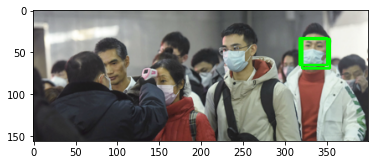

In [33]:
cv2.rectangle(image, bl, tr, (0,255,0),2)
cv2.rectangle(image, temp[0], temp[1], (0,255,0),2)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

In [35]:
pil_img = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
crop = [xl, yt, xr, yb]
crop = [temp[0][0], temp[0][1], temp[1][0], temp[1][1]]
crop

[318, 33, 351, 65]

In [ ]:
pil_crop = pil_img.crop(crop)
pil_crop.show()

tol .4
172, 402

.425
177, 416, corruption

tol .45
183, 429, corruption high

bot left only 
.2

170, 389

.3
corruption high
196, 472